MEDICAL ASSISTANT AGENT

Overview
This notebook implements a non-trivial medical system that solve real life challenges with increase patient flow and health professionals workload. It leverages the power of large language models to simulate specialized agents working together to provide comprehensive user satisfaction.

Motivation
I am a healthcare professional and one of the challege we face is increase patient flow, most times patient stay long time in queue only to findout they will be referered to another specialist or can have a first aid solution if they were well informed. This made me to build a complex system that can address this problem.

Key Components

This graph used the power of llm for natural language processing
Power of Agent in state
It used the concept of subgraphs for making the system modular and easy to interact as well as debug
It used the concept of parallelization
It utilizes tools
The overal system is open source


Methods: 

Two Subgraphs: - Chatbot subgraph= which is a graph to manage medical queries, it has a node using a RAG system for analyzing user symptoms and returning the condition, then another node for webscrapping which collects the condition and pass to a standardard medical website used in the UK and US,  it also has a conditional loop incase the condition returned is not found on the website, it gets the solution from our knowledge base which is "encyclopedia of medicine".
Summarize message subgraph= which summarizes the messages in state when it goes beyond 6.
Main Entry graph: This is my conversational assistant/agent that starts my graph. it can invoke my tools when necessary and also route as appropriate.
ToolNode: this is for my appointment management, a user can create, verify, uodate, or even delete appointment.(You can use google calender, which can work)
Human-in-the-loop: this interupt the main graph, its customizable. using a No-op node will be a nice customization

Conclusion:
This system is for development, and not for production as it needs additional security. 
Future Improvement- This agent will benefit from futher input from the community in adding other functionality especially H-i-L for a medical professional to update the state if need be before answer is sent to user.
Making it a voice assiatnt for better user experience

HAPPY CODING!!!

MEDICAL ASSITANT is an agent that act as a front desk for patients, it can recommend first aid and manage appointments with the doctors

This non-trival agent has access to a medical knowledge, standardized medical website for best upto date recommendations.
There is human-in-the-loop and tool calling.

Thanks to langchain,langgraph,openai and google

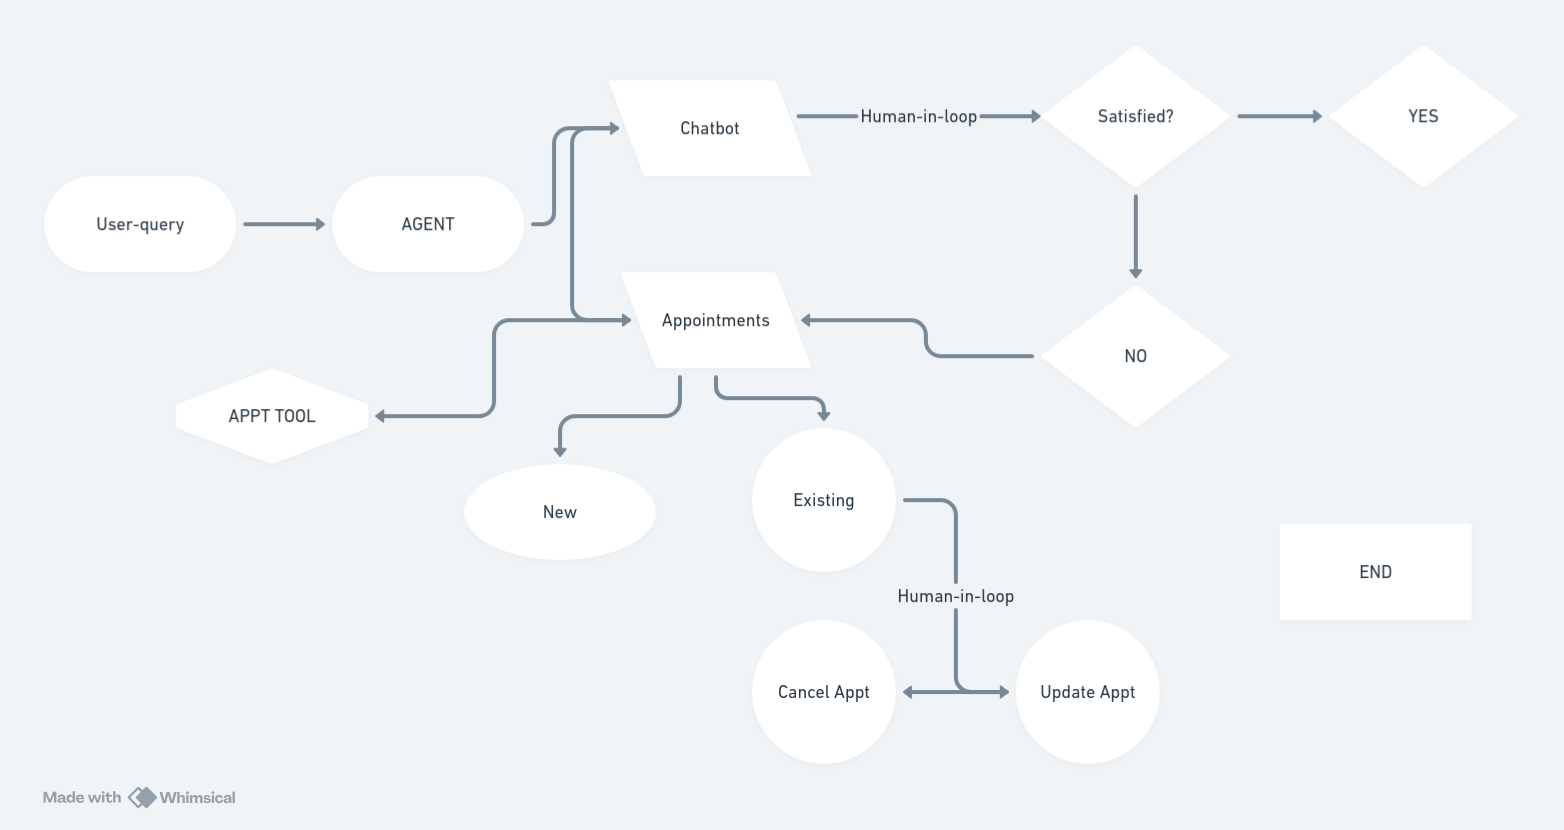

In [330]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

In [2]:
!pip install -q langsmith

In [3]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [4]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "MedicalAgent"

LANGCHAIN_API_KEY: ··········


In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [6]:
!pip install --quiet -U langchain_community langchain --upgrade langchain_core langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00


In [7]:
!pip install pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 2.8 MB/s eta 0:00:00


In [8]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.8 MB/s eta 0:00:00


In [10]:
!pip install langgraph

In [13]:
import operator
from langchain_openai import ChatOpenAI
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph.message import add_messages
from langgraph.graph import END, MessagesState

In [14]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class DocState(TypedDict):
    condition: str
    messages: Annotated[list, add_messages]

In [39]:
# Define the template for the prompt
template = """
You are a highly knowledgeable medical assistant. Using the provided context, carefully analyze the user's question to determine the most relevant medical condition.

Context: {context}
Question: {question}

Instructions:
1. If the question asks for the meaning or definition of a medical condition, respond with the medical condition only.
2. If the question describes symptoms or other details, analyze them in light of the context and respond with the name of the most likely medical condition only.
3. If the context does not provide sufficient information to determine a condition or define a term, return "none" instead of guessing.

Ensure your response is precise and aligns strictly with the provided context.
"""

# Define the prompt template
prompt1 = ChatPromptTemplate.from_template(template)


In [331]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader  # Import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings


# Set embeddings
embed = OpenAIEmbeddings()

# Docs to index
file_path = "/content/Medical_book.pdf"

def build_index_and_retrieve(state:DocState):
    """ Node to build index and retrieve """
    question = state["messages"][-1].content
    # Set embeddings
    embed = OpenAIEmbeddings()

    # Load PDF and extract content
    loader = PyPDFLoader(file_path)
    data = loader.load()
    extracted_doc = "".join(page.page_content for page in data)

    # Split document into chunks
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, length_function=len)
    doc_splits = text_splitter.create_documents([extracted_doc])

    # Create vectorstore and retriever
    vectorstore = Chroma.from_documents(doc_splits, collection_name="rag-chroma", embedding=embed)
    retriever = vectorstore.as_retriever()

    # Define chain and retrieve answer
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt1
        | llm
        | StrOutputParser()
    )
    output = chain.invoke(question)

    return {"condition": [output]}

In [41]:
# Define the template for the prompt
template = """You are a medical assistant providing information based on the condition provided. Use the available context to answer the user's question accurately. If condition is NONE return "i'm sorry i am not sure of what you are asking", state that you are unable to provide an answer, do not make up an answer, All answer must come only from the context. If the information you suggests is a medical intervention, advise the user to consider booking an appointment with a doctor if symptoms persist.

context: {context}
question: {question}


Respond directly with helpful information based on the condition and only from the context. If unsure or lacking specific information, say, "I'm unable to provide an answer for that." If the condition warrants medical consultation, add, "If symptoms persist, you may want to book an appointment to see a doctor."

"""

# Define the prompt template
prompt2 = ChatPromptTemplate.from_template(template)


In [42]:
from langchain.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser

async def analyze_and_scrape(state: DocState):
    """
    Node that analyzes the user query, retrieves condition details using WebBaseLoader, and processes the context.
    """
    condition = state["condition"]

    # Handle condition as a list or string
    if isinstance(condition, list):
        condition = condition[0].strip()

    # Validate condition
    if not condition or condition.lower() == "none":
        return {
            "messages": [
                "I'm sorry, I am not sure what you are asking."
            ]
        }

    # Construct the URL
    mayo_url = f"https://www.mayoclinic.org/diseases-conditions/{condition.replace(' ', '-').lower()}/"
    nhs_url = f"https://www.nhs.uk/conditions/{condition.replace(' ', '-').lower()}/"
    site_urls = [nhs_url, mayo_url]
    print(f"Fetching URLs: {site_urls}")

    # Use WebBaseLoader to fetch the page content
    try:
        loader = WebBaseLoader(site_urls)
        docs = await loader.aload()  # Asynchronous call to fetch documents

        # If no documents are fetched, route to vector store
        # Update: Preserve the original condition and add route_to_vectorstore flag
        if not docs or len(docs) == 0:
            return {"condition": condition, "route_to_vectorstore": True}

        # Extract the text content from the first document
        page_data = docs[0].page_content
    except Exception as e:
        print(f"Error fetching content from {site_urls}: {e}")
        # Update: Preserve the original condition and add route_to_vectorstore flag
        return {"condition": condition, "route_to_vectorstore": True}  # Route to vector store on error


    # Build the chain
    question = state["messages"][-1].content
    chain = (
        RunnablePassthrough()
        | prompt2
        | llm
        | StrOutputParser()
    )

    # Limit context size for better processing
    context = page_data[:3000]
    print({
        "context": context[:500],  # Debugging input to the chain
        "question": question
    })

    # Execute the chain
    output = chain.invoke({
        "context": context,
        "question": question
    })

    # Return the generated output
    return {"messages": [output]}


In [43]:
template = """
You are a knowledgeable and reliable medical assistant. You will receive a user's question, condition , and relevant medical context. Your task is to:

1. Provide a clear and accurate answer to the question based only on the information available in the context.
2. If the context does not contain enough information to answer the question accurately, respond with:
   "I'm sorry, I cannot answer this question based on the provided information. Please provide additional context or rephrase your query."

Question: {question}
Context: {context}

Your response should be concise, informative, and strictly based on the context provided.
"""

# Define the prompt template
prompt3 = ChatPromptTemplate.from_template(template)


In [19]:
# For demonstration, reusing the build_index_and_retrieve logic
embed = OpenAIEmbeddings()
loader = PyPDFLoader("/content/Medical_book.pdf")
data = loader.load()
extracted_doc = "".join(page.page_content for page in data)

        # Create vector store
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200, length_function=len)
doc_splits = text_splitter.create_documents([extracted_doc])

vectorstore = Chroma.from_documents(doc_splits, collection_name="rag-chroma", embedding=embed)
retriever = vectorstore.as_retriever()

In [44]:
async def route_to_vectorstore(state:DocState):

    """ Node to answer question routed """

    # Get state
    # Get the content of the last message, assuming it's the question
    question = state["messages"][-1].content
    condition = state["condition"]

    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt3
        | llm
        | StrOutputParser()
    )
    # Pass the question string directly to the chain
    answer = chain.invoke(question)

    return {"messages": [answer]}

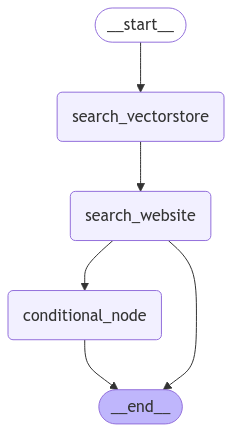

In [45]:
# Initialize the state graph
Vbuilder = StateGraph(DocState)

# Add nodes
Vbuilder.add_node("search_website", analyze_and_scrape)
Vbuilder.add_node("search_vectorstore", build_index_and_retrieve)
Vbuilder.add_node("conditional_node", route_to_vectorstore)


# Flow
Vbuilder.add_edge(START, "search_vectorstore")
Vbuilder.add_edge("search_vectorstore", "search_website")
Vbuilder.add_edge("search_website", "conditional_node")
Vbuilder.add_edge("search_website", END)
Vbuilder.add_edge("conditional_node", END) # Connect conditional_node to END

# Compile and visualize the graph
graph = Vbuilder.compile()

# Display graph (Mermaid format)
display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
import nest_asyncio
import asyncio

# Apply nest_asyncio patch
nest_asyncio.apply()

# Ask the question and invoke the graph
question = "what is type 2 diabetes?"  # Your question here
result = asyncio.run(graph.ainvoke({"messages": [question]}))

# Print the result
print(result)  # Access the answer from the 'messages' key

Fetching URLs: ['https://www.nhs.uk/conditions/type-ii-diabetes/', 'https://www.mayoclinic.org/diseases-conditions/type-ii-diabetes/']


Fetching pages: 100%|##########| 2/2 [00:00<00:00,  2.69it/s]


Error fetching content from ['https://www.nhs.uk/conditions/type-ii-diabetes/', 'https://www.mayoclinic.org/diseases-conditions/type-ii-diabetes/']: object list can't be used in 'await' expression
{'condition': 'Type II diabetes', 'messages': [HumanMessage(content='what is type 2 diabetes?', additional_kwargs={}, response_metadata={}, id='22de5662-903a-43e4-bbbf-e5ad3c99e70e'), HumanMessage(content='Type 2 diabetes is characterized by insulin resistance. It is treatable by a number of therapeutic approaches, and many cases of insulin resistance may be asymptomatic due to normal increases in insulin secretion. Some cases can be controlled by diet.', additional_kwargs={}, response_metadata={}, id='ea5b59ed-f27d-47dc-acaf-d03d19fccc38')]}


## SUB-GRAPH TO SUMMARIZE MESSAGES

In [47]:
!pip install langgraph

In [152]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState


class State(TypedDict):
    summary: list
    messages: Annotated[list, add_messages]

# Define the logic to call the model
def call_model(state: State):

    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:

        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END

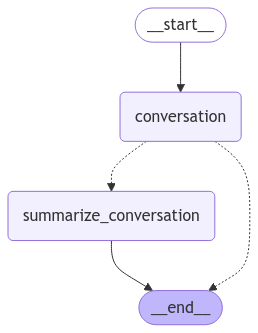

In [153]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

##TOOL BUILDING FOR APPOINTMENT MANAGEMENT

In [50]:
!pip install pydantic[email]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 9.7 MB/s eta 0:00:00


In [51]:
from pydantic import BaseModel, Field, EmailStr, ValidationError
from datetime import datetime
import pandas as pd
from threading import Lock
from langchain.tools import tool

# Thread-safe lock for data operations
lock = Lock()

# Define the Pydantic model for an appointment
class Appointment(BaseModel):
    name: str
    address: str
    email: EmailStr
    phone_number: str = Field(pattern=r'^\+?\d{10,15}$')
    date_time: datetime
    additional_info: str = ""

# Initialize the dataframe for storing appointments
appointments_df = pd.DataFrame(columns=Appointment.__fields__.keys())

@tool
def create_appointment(data: dict) -> str:
    """
    Create a new appointment entry based on the data provided.

    Args:
        data (dict): Dictionary containing appointment information.

    Returns:
        str: Confirmation message or error.
    """
    try:
        appointment = Appointment(**data)
        global appointments_df

        with lock:
            # Check for conflicting appointments
            if not appointments_df.empty:
                conflicting_appointments = appointments_df[
                    pd.to_datetime(appointments_df["date_time"]) == appointment.date_time
                ]
                if not conflicting_appointments.empty:
                    return f"Conflict detected! Another appointment is scheduled at {appointment.date_time}."

            appointments_df = pd.concat([appointments_df, pd.DataFrame([appointment.dict()])], ignore_index=True)

        return f"Great! Appointment created successfully for {appointment.name} on {appointment.date_time}."
    except ValidationError as e:
        return f"Error creating appointment: {e}"

@tool
def update_appointment(email: str, updates: dict) -> str:
    """
    Update an existing appointment entry based on the email.

    Args:
        email (str): The email for the appointment to update.
        updates (dict): Dictionary containing fields to update.

    Returns:
        str: Confirmation message or error.
    """
    global appointments_df
    with lock:
        if email not in appointments_df['email'].values:
            return f"No appointment found with email {email}."

        # Filter updates to only include valid fields
        valid_updates = {k: v for k, v in updates.items() if k in Appointment.__fields__}
        if not valid_updates:
            return "No valid fields provided for update."

        # Update the appointment in the dataframe
        appointments_df.loc[appointments_df['email'] == email, list(valid_updates.keys())] = list(valid_updates.values())
        return f"Your appointment with email {email} was updated successfully."

@tool
def delete_appointment(email: str) -> str:
    """
    Delete an existing appointment based on the email.

    Args:
        email (str): The email for the appointment to delete.

    Returns:
        str: Confirmation message.
    """
    global appointments_df
    with lock:
        if email not in appointments_df['email'].values:
            return f"No appointment found with email {email}."

        # Delete the appointment from the dataframe
        appointments_df = appointments_df[appointments_df['email'] != email]
        return f"Your appointment with email {email} was deleted successfully."

@tool
def verify_appointment(email: str) -> str:
    """
    Verify an existing appointment based on the email.

    Args:
        email (str): The email to verify the appointment details.

    Returns:
        str: Appointment details or an error message.
    """
    global appointments_df
    with lock:
        if email not in appointments_df['email'].values:
            return f"No appointment found with email {email}."

        # Retrieve and format the appointment details
        appointment_details = appointments_df[appointments_df['email'] == email].to_dict(orient="records")[0]
        details_str = "\n".join([f"{key}: {value}" for key, value in appointment_details.items()])
        return f"Appointment details for {email}:\n{details_str}"

@tool
def check_availability(date_time: datetime) -> str:
    """
    Check for conflicting appointments at a specific date and time.

    Args:
        date_time (datetime): The requested appointment time.

    Returns:
        str: Availability status.
    """
    global appointments_df
    with lock:
        conflicting_appointments = appointments_df[
            pd.to_datetime(appointments_df["date_time"]) == date_time
        ]
        if not conflicting_appointments.empty:
            return f"Conflict detected! Another appointment is scheduled at {date_time}."
        return "The requested time slot is available."


In [52]:
tools = [create_appointment, update_appointment, delete_appointment, verify_appointment, check_availability]

In [53]:
# two LLM models
model_with_tools = llm.bind_tools(tools)
model_with_structured_output = llm.with_structured_output(Appointment)

##MAIN GRAPH ENTRY

In [54]:
%pip install --quiet -U langgraph-checkpoint-sqlite

In [55]:
!mkdir state_db

#Using Sqlite to maintain memory locally

In [93]:
import sqlite3
# In memory
#conn = sqlite3.connect(":memory:", check_same_thread = False)
db_path = "state_db/med.db"
#conn = sqlite3.connect(db_path, check_same_thread=False)

In [94]:
# Here is our checkpointer
#from langgraph.checkpoint.sqlite import SqliteSaver
#memory = SqliteSaver(conn)

In [95]:
import asyncio
from contextlib import AsyncExitStack
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

stack = AsyncExitStack()
memory = await stack.enter_async_context(AsyncSqliteSaver.from_conn_string(db_path))

In [111]:

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore

In [ ]:
template="""You are a helpful assistant, that process user's query and route to eithe chatbot for medical or health queries or tools node for appointment management"""

prompt = ChatPromptTemplate.from_template(template)

In [ ]:
# Structured Output Processor Node
def structured_output_processor(state: EntryGraphState):
    """
    Processes user input and outputs structured data for appointment management.
    """
    try:
        structured_response = model_with_structured_output.invoke({"question": state["messages"][-1].content})
        logging.info(f"Structured output: {structured_response}")
        return {"tool_output": structured_response}
    except Exception as e:
        error_message = "Error occurred while processing structured output."
        logging.error(f"Structured Output Processor Error: {e}")
        state["error"] = error_message
        return {"messages": [AIMessage(content=error_message)]}




# Assistant Node
def Agent(state: EntryGraphState):
    """
    Conversational node that handles user input and routes to tools or chatbot based on intent.
    """
    #try:
    last_message = state["messages"][-1].content
    #    logging.info(f"User query: {last_message}")

    # Process user input with the assistant model
    # Assuming 'prompt' is a ChatPromptTemplate and needs formatting:
    formatted_prompt = prompt.format(input=last_message) # Format the prompt template with the last message
    response = model_with_tools.invoke([HumanMessage(content=formatted_prompt)]) # Pass the formatted prompt as a HumanMessage
    return {"messages":[response]}

# Define `tools_condition` for routing to the tools node
def tools_condition(state: EntryGraphState) -> str:
    """
    Determines whether to route a user query to the tools node if relates to appointment management.

    Args:
        state (EntryGraphState): The state of the graph including messages.

    Returns:
        str: The next node to route to, either "tools" or "chatbot".
    """
    user_query = state["messages"][-1].content.lower()

    # Keywords indicating the user wants to manage appointments
    appointment_keywords = [
        "appointment", "book", "schedule", "update", "delete", "verify", "availability"
    ]

    if any(keyword in user_query for keyword in appointment_keywords):
        logging.info("Routing to tools node based on user query.")
        return "tools"
    else:
        logging.info("Routing to chatbot node for medical queries.")
        return "chatbot"

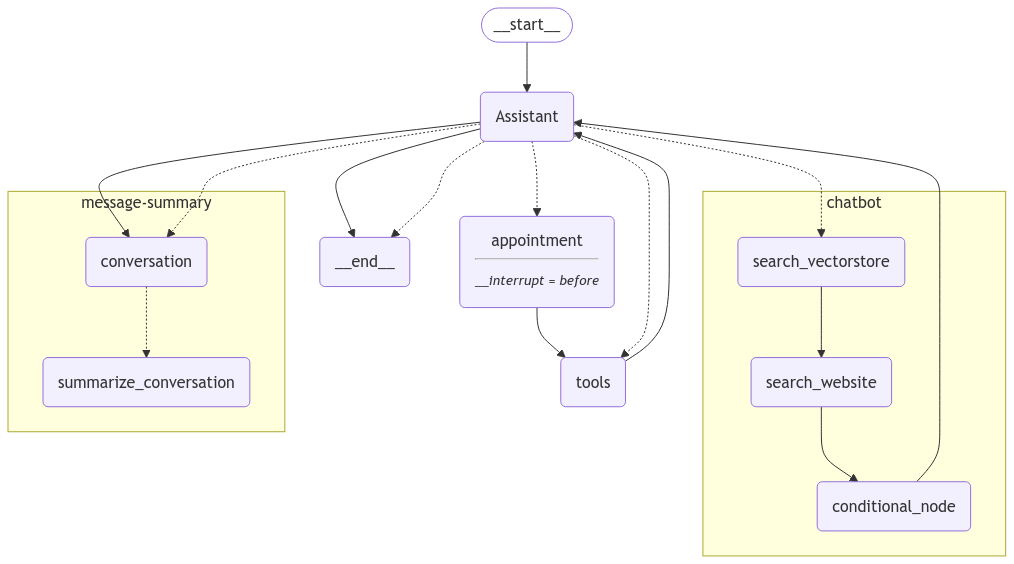

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from typing import Annotated, TypedDict
from threading import Lock
import logging

logging.basicConfig(level=logging.INFO)

# Define Entry Graph State
class EntryGraphState(TypedDict):
    summary: list
    condition: str
    tool_output: str
    messages: Annotated[list, add_messages]
    error: str



# Initialize the main entry graph
entry_builder = StateGraph(EntryGraphState)

# Add nodes to the graph
entry_builder.add_node("Assistant", Agent)  # Main assistant handler node
entry_builder.add_node("chatbot", Vbuilder.compile())  # Chatbot subgraph for medical queries
entry_builder.add_node("message-summary", workflow.compile())  # Summary subgraph for summarizing conversations
tool_node = ToolNode(tools=[
    create_appointment, update_appointment, delete_appointment, verify_appointment, check_availability
])
entry_builder.add_node("tools", tool_node)  # Instantiate AppointmentTool
entry_builder.add_node("appointment", structured_output_processor)  # Node for processing user queries

# Define the main flow of the graph
entry_builder.add_edge(START, "Assistant")  # Entry point to the assistant
entry_builder.add_conditional_edges("Assistant", tools_condition)  # Route dynamically based on query
entry_builder.add_edge("Assistant", "message-summary")  # Route to message summarization if needed
entry_builder.add_edge("tools", "Assistant")  # Return to assistant from tools
entry_builder.add_edge("Assistant", "chatbot")  # Return to assistant from chatbot
entry_builder.add_edge("appointment", "tools")  # Route structured output to tools
entry_builder.add_edge("Assistant", END)

# Compile the graph with a checkpointer for memory management
graph = entry_builder.compile(
    interrupt_before=["appointment"],  # Interrupt for human feedback or tool usage
    checkpointer=memory  # SQLite memory checkpointer for state persistence
)

# Visualize the graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
import nest_asyncio
import asyncio


# Apply nest_asyncio patch
nest_asyncio.apply()

config = {"configurable": {"thread_id": "4"}}

# Ask the question and invoke the graph
question = HumanMessage(content="what is acne?")  # Your question here
# Pass 'config' and 'stream_mode' to 'ainvoke' instead of 'asyncio.run'
output = asyncio.run(graph.ainvoke({"messages": [question]}, config, stream_mode="value"))



In [ ]:
import nest_asyncio
import asyncio
from langchain.schema import HumanMessage
# Import necessary classes
from langchain.prompts import ChatPromptTemplate

# Apply nest_asyncio patch
nest_asyncio.apply()

config = {"configurable": {"thread_id": "1"}}

# Your original question
question_content = "i have frequent urine and leg swelling?"  

# Create a HumanMessage object from the question content
message = HumanMessage(content=question_content) 

# Ask the question and invoke the graph
# Pass the formatted message to 'ainvoke'
output = asyncio.run(graph.ainvoke({"messages": [message]}, config, stream_mode="value"))

Fetching URLs: ['https://www.nhs.uk/conditions/acute-kidney-failure/', 'https://www.mayoclinic.org/diseases-conditions/acute-kidney-failure/']


Fetching pages: 100%|##########| 2/2 [00:00<00:00,  2.43it/s]


Error fetching content from ['https://www.nhs.uk/conditions/acute-kidney-failure/', 'https://www.mayoclinic.org/diseases-conditions/acute-kidney-failure/']: object list can't be used in 'await' expression


GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT